# Atividade 1 - Etapa 4 - Melhores metodologias de aprendizagem clássica

In [1]:
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# áudios que temos certeza que são deglutições - 28, 73, 83, 105, 111, 112, 115, 133, 180, 183
a00028 = 'MP3/a00028.mp3'
a00073 = 'MP3/a00073.mp3'
a00083 = 'MP3/a00083.mp3'
a00105 = 'MP3/a00105.mp3'
a00111 = 'MP3/a00111.mp3'
a00112 = 'MP3/a00112.mp3'
a00115 = 'MP3/a00115.mp3'
a00133 = 'MP3/a00133.mp3'
a00180 = 'MP3/a00180.mp3'
a00183 = 'MP3/a00183.mp3'

# caminho para os áudios
bons = [os.path.join('MP3/', os.path.basename(a00028)), os.path.join('MP3/', os.path.basename(a00073)),
        os.path.join('MP3/', os.path.basename(a00083)), os.path.join('MP3/', os.path.basename(a00105)),
        os.path.join('MP3/', os.path.basename(a00111)), os.path.join('MP3/', os.path.basename(a00112)),
        os.path.join('MP3/', os.path.basename(a00115)), os.path.join('MP3/', os.path.basename(a00133)),
        os.path.join('MP3/', os.path.basename(a00180)), os.path.join('MP3/', os.path.basename(a00183))]

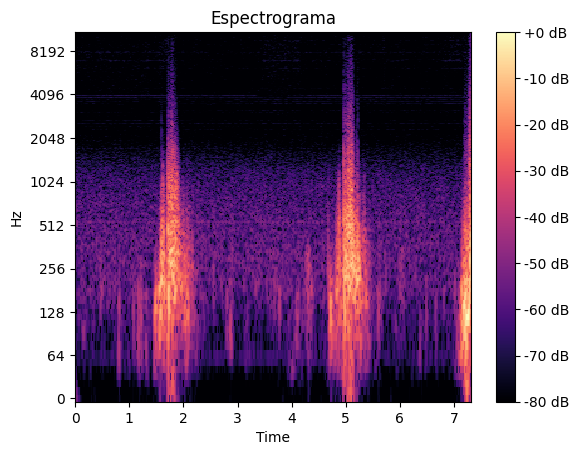

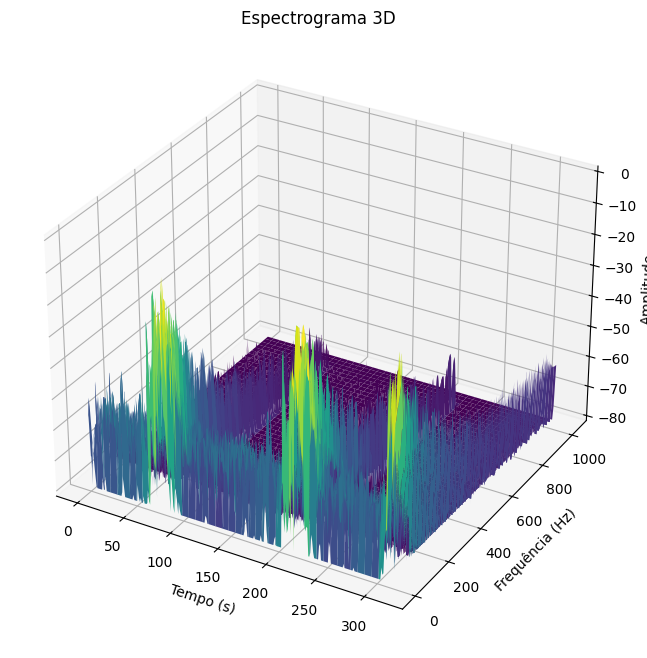

In [3]:
import librosa.display
from mpl_toolkits.mplot3d import Axes3D

# Carregar o sinal de áudio
y, sr = librosa.load('MP3/a00028.mp3')

# Definir o intervalo de tempo desejado (em segundos)
inicio = 0
fim = 7.5

# Converter o intervalo de tempo para amostras
inicio_amostra = int(inicio * sr)
fim_amostra = int(fim * sr)

# Extrair o intervalo de sinal de áudio
sinal_intervalo = y[inicio_amostra:fim_amostra]

# Calcular o espectrograma
D = librosa.amplitude_to_db(np.abs(librosa.stft(sinal_intervalo)), ref=np.max)

# Plotar o espectrograma
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma')
plt.show()

# Define the x and y coordinates
x = np.arange(D.shape[1])
y = np.arange(D.shape[0])

# Create a meshgrid from the x and y coordinates
X, Y = np.meshgrid(x, y)

# Plot the spectrogram in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, D, cmap='viridis')

# Set labels and title
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência (Hz)')
ax.set_zlabel('Amplitude')
ax.set_title('Espectrograma 3D')

# Show the plot
plt.show()

100%|██████████| 10/10 [00:00<00:00, 44.54it/s]


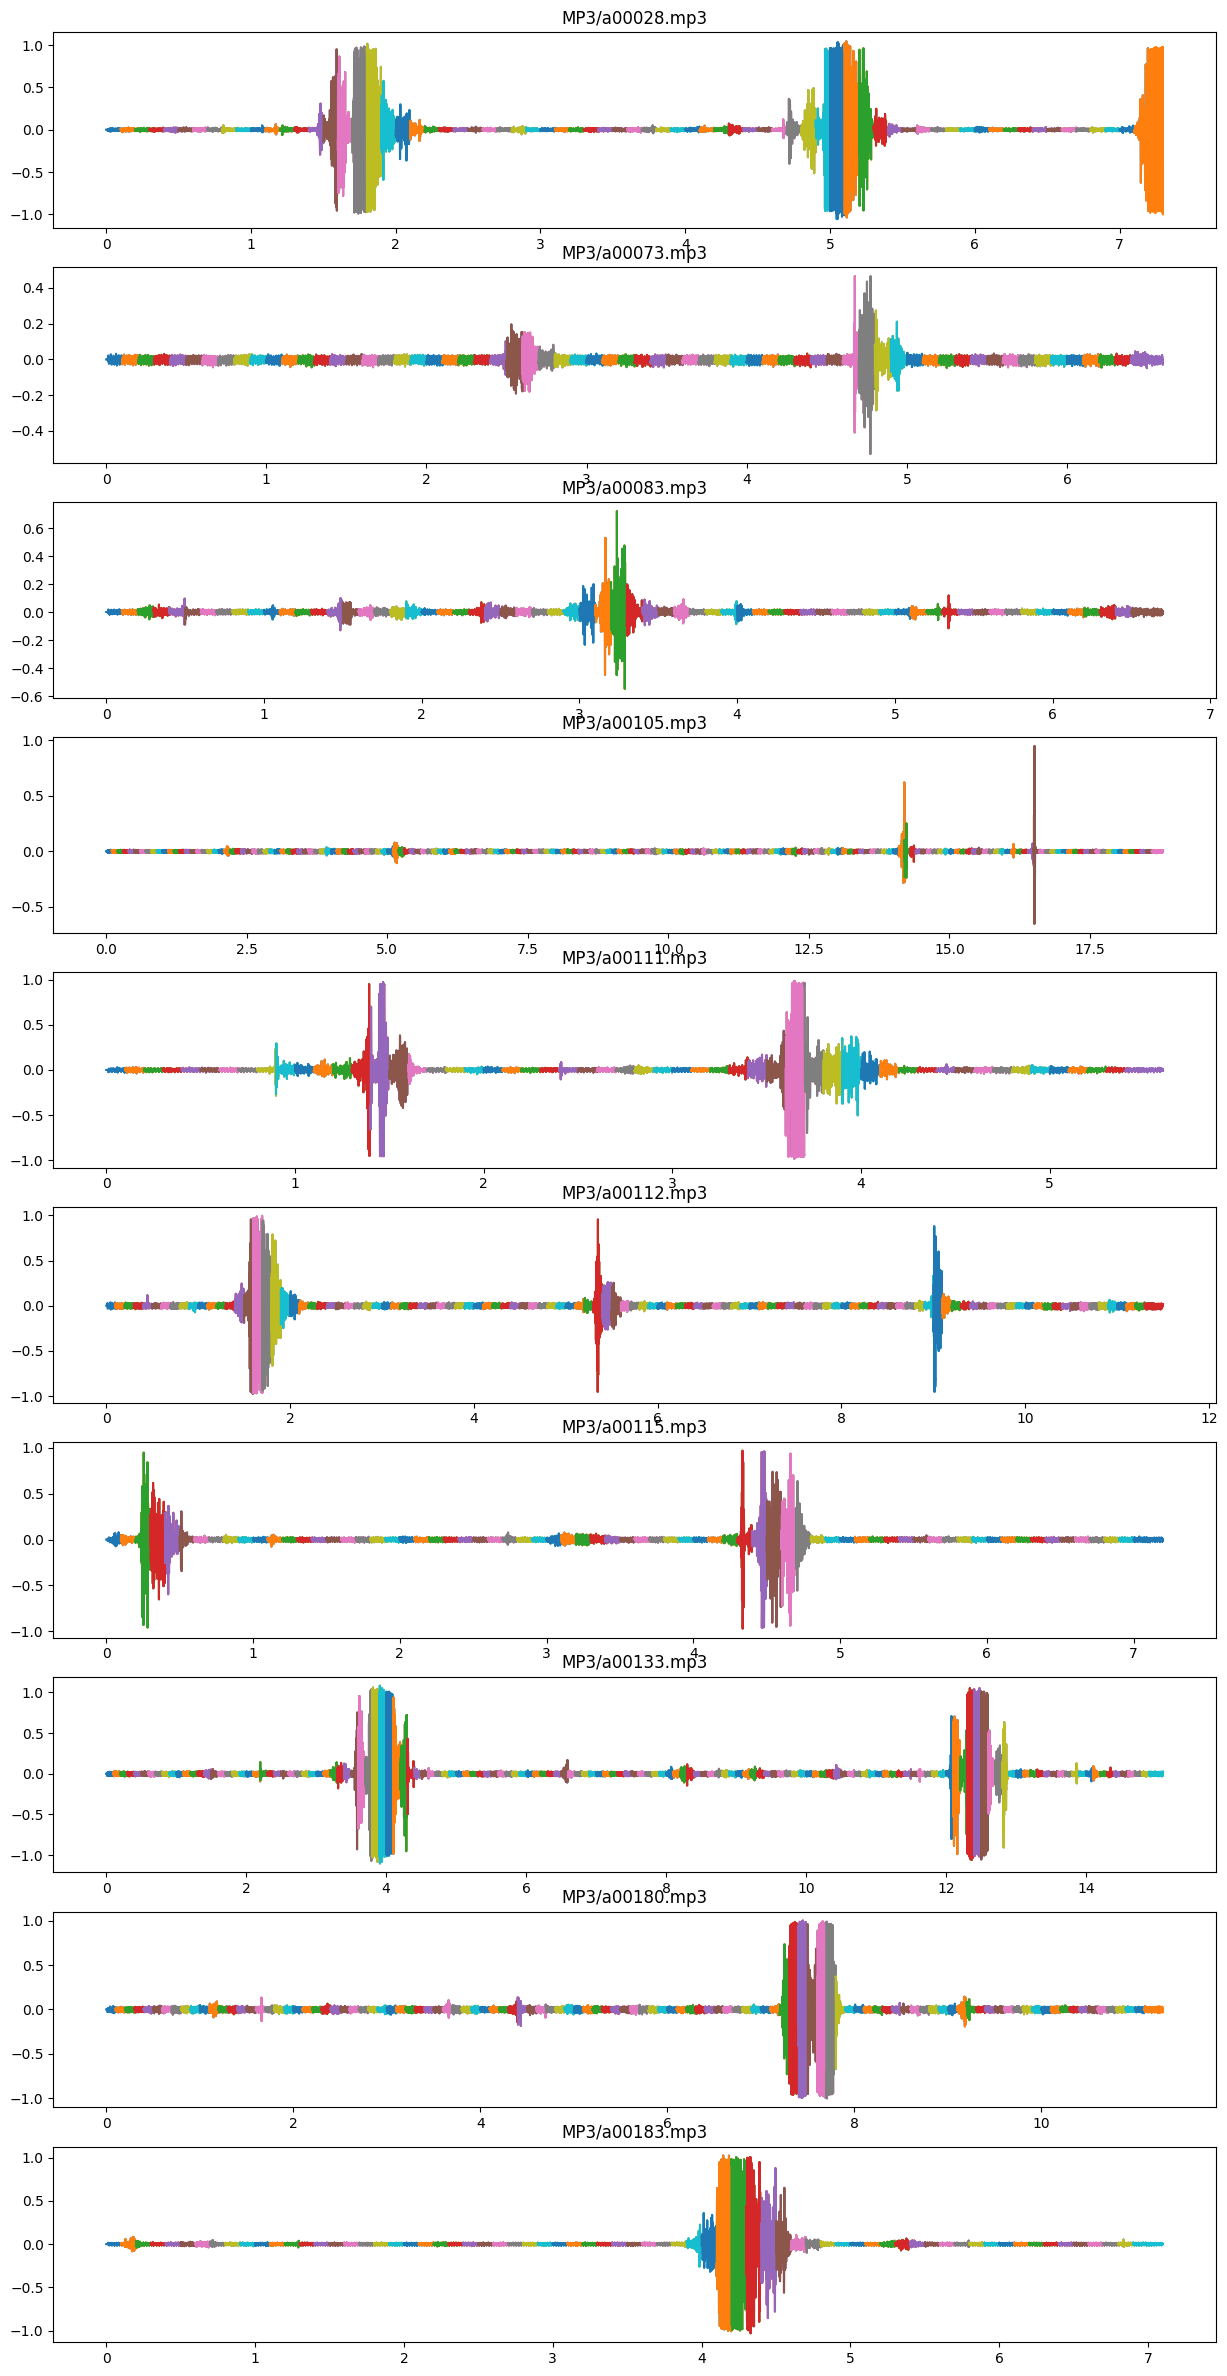

In [4]:
dados = []
nomes = []

for b in tqdm(bons):
    nome = os.path.basename(b)[:-4]
    y, sr = librosa.load(b)
    x = np.arange(len(y))/sr
  
    janela = int(0.2 * sr)
    passo = int(0.1 * sr)
    
    linha = []

    for i in range(0, len(y), int(passo)):
        max = i + janela
        if max > len(y):
            break
        linha.append((x[i:max], y[i:max]))    

    nomes.append(nome)
    dados.append(linha)


fig, ax = plt.subplots(len(dados), 1, figsize=(15, 3*len(dados)))
for i, linha in enumerate(dados):
    ax[i].set_title(bons[i])
    for x, y in linha:
        ax[i].plot(x, y)
plt.show()

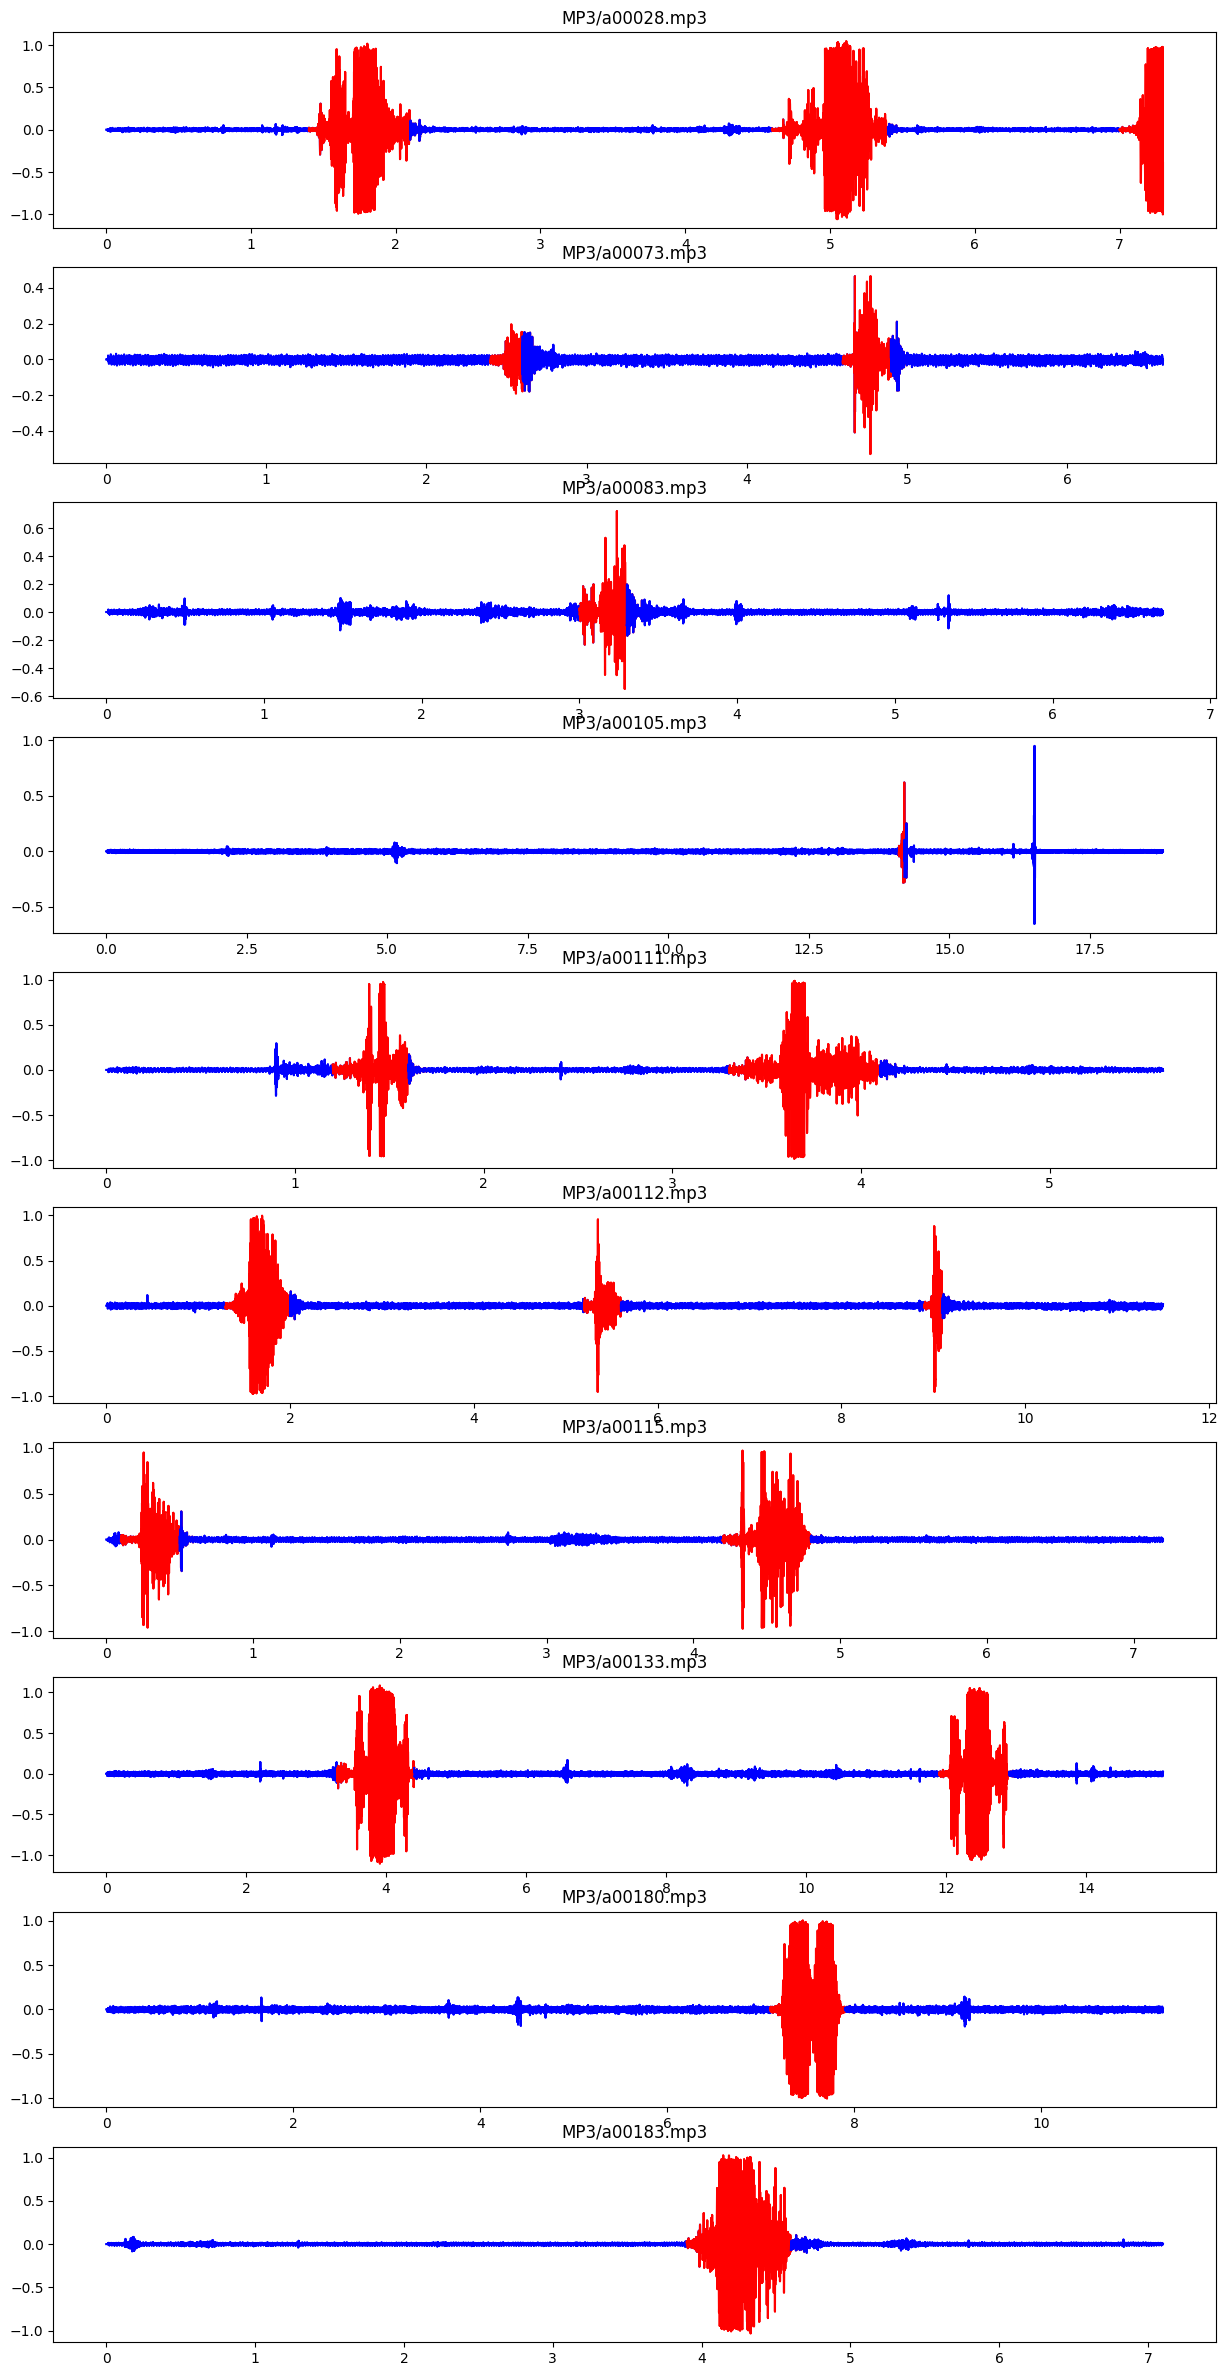

In [5]:
# detector de anomalias
from sklearn.ensemble import IsolationForest

X = []
for i, linha in enumerate(dados):
    for _, y in linha:
        X.append(y)

clf = IsolationForest(contamination=0.1)
clf.fit(X)
ano = clf.predict(X)
ano = (ano == -1)

fig, ax = plt.subplots(len(dados), 1, figsize=(15, 3*len(dados)))
n=-1
for i, linha in enumerate(dados):
    ax[i].set_title(bons[i])
    for x, y in linha:
        n+=1
        ax[i].plot(x, y, color='red' if ano[n] else 'blue')
plt.show()

In [6]:
# detector de anomalias
import pandas as pd
import warnings
from sklearn.ensemble import IsolationForest
warnings.filterwarnings('ignore')

deteccao = []
count = 0

for linha in tqdm(dados):
    for x, y in linha:        
        #extração espectral
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        flatness = librosa.feature.spectral_flatness(y=y)
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        #extração temporal
        rmse = librosa.feature.rms(y=y)
        zcr = librosa.feature.zero_crossing_rate(y=y)
        #outras extrações
        hpss = librosa.effects.hpss(y=y)
        melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        
        atributos = [nomes[count]]
        # fazer a média dos valore
        atributos.extend(np.mean(mfcc,axis=1))
        atributos.extend(np.mean(spec_cent,axis=1))
        atributos.extend(np.mean(spec_bw,axis=1))
        atributos.extend(np.mean(flatness,axis=1))
        atributos.extend(np.mean(spec_contrast,axis=1))
        atributos.extend(np.mean(rolloff,axis=1))
        atributos.extend(np.mean(chroma_stft,axis=1))
        atributos.extend(np.mean(tonnetz,axis=1))
        atributos.extend(np.mean(rmse,axis=1))
        atributos.extend(np.mean(zcr,axis=1))
        atributos.extend(np.mean(hpss,axis=1))
        atributos.extend(np.mean(melspectrogram,axis=1))

        #desvio padrão
        atributos.extend(np.std(mfcc,axis=1))
        atributos.extend(np.std(spec_cent,axis=1))
        atributos.extend(np.std(spec_bw,axis=1))
        atributos.extend(np.std(flatness,axis=1))
        atributos.extend(np.std(spec_contrast,axis=1))
        atributos.extend(np.std(rolloff,axis=1))
        atributos.extend(np.std(chroma_stft,axis=1))
        atributos.extend(np.std(tonnetz,axis=1))
        atributos.extend(np.std(rmse,axis=1))
        atributos.extend(np.std(zcr,axis=1))
        atributos.extend(np.std(hpss,axis=1))
        atributos.extend(np.std(melspectrogram,axis=1))

        #amplitude peak-to-peak
        atributos.extend(np.ptp(mfcc,axis=1))
        atributos.extend(np.ptp(spec_cent,axis=1))
        atributos.extend(np.ptp(spec_bw,axis=1))
        atributos.extend(np.ptp(flatness,axis=1))
        atributos.extend(np.ptp(spec_contrast,axis=1))
        atributos.extend(np.ptp(rolloff,axis=1))
        atributos.extend(np.ptp(chroma_stft,axis=1))
        atributos.extend(np.ptp(tonnetz,axis=1))
        atributos.extend(np.ptp(rmse,axis=1))
        atributos.extend(np.ptp(zcr,axis=1))
        atributos.extend(np.ptp(hpss,axis=1))
        atributos.extend(np.ptp(melspectrogram,axis=1))

        deteccao.append(atributos)
    
    #incremento o contador
    count += 1

warnings.filterwarnings('default')

df = pd.DataFrame(deteccao)
df.head(10)

100%|██████████| 10/10 [02:12<00:00, 13.30s/it]


,0,1,2,3,4,5,6,7,8,9,...,534,535,536,537,538,539,540,541,542,543
0,a00028,-357.239594,108.535172,33.443836,-11.705862,-20.590889,2.971202,-2.553973,-4.101649,-12.752204,...,0.000230,0.000123,0.000120,0.000129,0.000127,0.000110,0.000142,0.000081,0.000048,0.000004
1,a00028,-352.471893,110.284492,35.265484,-13.060148,-23.493683,3.977764,-0.851560,-4.813551,-12.525639,...,0.000117,0.000067,0.000145,0.000096,0.000086,0.000069,0.000141,0.000067,0.000035,0.000003
2,a00028,-353.375336,107.047028,31.723701,-14.330480,-28.329737,0.274049,-3.601837,-3.927103,-11.903187,...,0.000058,0.000141,0.000075,0.000111,0.000112,0.000095,0.000106,0.000064,0.000043,0.000004
3,a00028,-349.974091,111.493881,35.747177,-13.269750,-26.284750,2.246641,-4.863941,-5.609868,-14.087089,...,0.000155,0.000115,0.000089,0.000111,0.000061,0.000053,0.000096,0.000090,0.000054,0.000006
4,a00028,-349.963104,111.361320,34.163788,-14.051064,-23.633812,2.861266,-4.815115,-8.133701,-14.087742,...,0.000123,0.000126,0.000070,0.000098,0.000072,0.000086,0.000100,0.000067,0.000035,0.000005
5,a00028,-351.571289,109.419159,34.126572,-13.463475,-27.055241,0.856416,-4.309851,-5.685105,-13.455380,...,0.000114,0.000122,0.000120,0.000094,0.000086,0.000056,0.000084,0.000126,0.000042,0.000004
6,a00028,-350.599976,110.196938,35.698029,-13.086098,-24.091885,1.870190,-5.013456,-4.043255,-11.826941,...,0.000084,0.000131,0.000169,0.000131,0.000132,0.000057,0.000074,0.000112,0.000049,0.000006
7,a00028,-349.294556,116.314857,39.796120,-9.455629,-16.406034,8.682145,-1.648021,-4.192031,-7.961789,...,0.000104,0.000047,0.000138,0.000093,0.000123,0.000064,0.000034,0.000094,0.000059,0.000005
8,a00028,-350.475647,114.888756,37.888786,-10.346184,-17.621998,8.503477,-1.170718,-2.939048,-8.043719,...,0.000108,0.000053,0.000115,0.000120,0.000095,0.000060,0.000058,0.000056,0.000016,0.000005
9,a00028,-354.372498,111.171997,38.044750,-9.803769,-20.252951,4.859674,-1.698121,-0.919590,-11.226261,...,0.000108,0.000122,0.000112,0.000065,0.000084,0.000092,0.000072,0.000063,0.000026,0.000004


In [7]:
# dividindo os dados em dataframes separados para cada áudio
grouped = df.groupby(0)
partes = [group for _, group in grouped]

unique_names = df[0].unique()

for name in unique_names:
    globals()[f'df_{name}'] = df[df[0] == name]
    globals()[f'df_{name}'].set_index(0, inplace=True)

display(df_a00073.head())
df_a00073.shape

,1,2,3,4,5,6,7,8,9,10,...,534,535,536,537,538,539,540,541,542,543
0,,,,,,,,,,,,,,,,,,,,,
a00073,-326.053894,92.508583,27.201725,13.802853,3.142781,2.083383,-0.875462,13.207769,-0.197209,2.789964,...,0.000274,0.000242,0.000238,0.000264,0.000305,0.000394,0.000418,0.000397,0.000221,0.000022
a00073,-321.468048,95.167175,26.235565,16.161293,1.035823,2.515931,-1.451517,13.493750,-2.606277,2.818512,...,0.000160,0.000176,0.000239,0.000197,0.000135,0.000167,0.000163,0.000130,0.000057,0.000012
a00073,-319.324890,95.813164,26.570005,14.692973,-1.455513,0.777586,-2.103080,14.194419,-1.545682,1.889961,...,0.000130,0.000195,0.000237,0.000148,0.000071,0.000153,0.000060,0.000124,0.000044,0.000019
a00073,-318.872925,97.896736,26.390680,15.533620,-0.853631,0.105751,-3.727321,14.869254,-2.801658,2.915491,...,0.000212,0.000140,0.000130,0.000120,0.000074,0.000106,0.000155,0.000137,0.000035,0.000007
a00073,-319.483032,95.673515,24.349346,14.816725,0.780974,1.085929,-0.564486,14.551860,-1.113732,2.595304,...,0.000221,0.000166,0.000137,0.000192,0.000161,0.000147,0.000128,0.000164,0.000070,0.000021


(65, 543)

In [8]:
df_isolation = df.drop(columns=[0])
df_isolation.head()

,1,2,3,4,5,6,7,8,9,10,...,534,535,536,537,538,539,540,541,542,543
0,-357.239594,108.535172,33.443836,-11.705862,-20.590889,2.971202,-2.553973,-4.101649,-12.752204,0.516550,...,0.000230,0.000123,0.000120,0.000129,0.000127,0.000110,0.000142,0.000081,0.000048,0.000004
1,-352.471893,110.284492,35.265484,-13.060148,-23.493683,3.977764,-0.851560,-4.813551,-12.525639,-0.099327,...,0.000117,0.000067,0.000145,0.000096,0.000086,0.000069,0.000141,0.000067,0.000035,0.000003
2,-353.375336,107.047028,31.723701,-14.330480,-28.329737,0.274049,-3.601837,-3.927103,-11.903187,-1.092449,...,0.000058,0.000141,0.000075,0.000111,0.000112,0.000095,0.000106,0.000064,0.000043,0.000004
3,-349.974091,111.493881,35.747177,-13.269750,-26.284750,2.246641,-4.863941,-5.609868,-14.087089,-3.804565,...,0.000155,0.000115,0.000089,0.000111,0.000061,0.000053,0.000096,0.000090,0.000054,0.000006
4,-349.963104,111.361320,34.163788,-14.051064,-23.633812,2.861266,-4.815115,-8.133701,-14.087742,-4.811247,...,0.000123,0.000126,0.000070,0.000098,0.000072,0.000086,0.000100,0.000067,0.000035,0.000005


In [9]:
from sklearn.ensemble import IsolationForest

# Initialize IsolationForest with desired parameters
clf = IsolationForest(contamination=0.1)  # You can adjust contamination as needed

# Fit the IsolationForest model to the feature data
clf.fit(df_isolation)

IsolationForest(contamination=0.1)

In [10]:
for name in unique_names:    
    predicao = clf.predict(globals()[f'df_{name}'])
    print(f'{name} | n° janelas: {len(predicao)}')
    print(predicao)

a00028 | n° janelas: 72
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1]
a00073 | n° janelas: 65
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
a00083 | n° janelas: 66
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
a00105 | n° janelas: 187
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

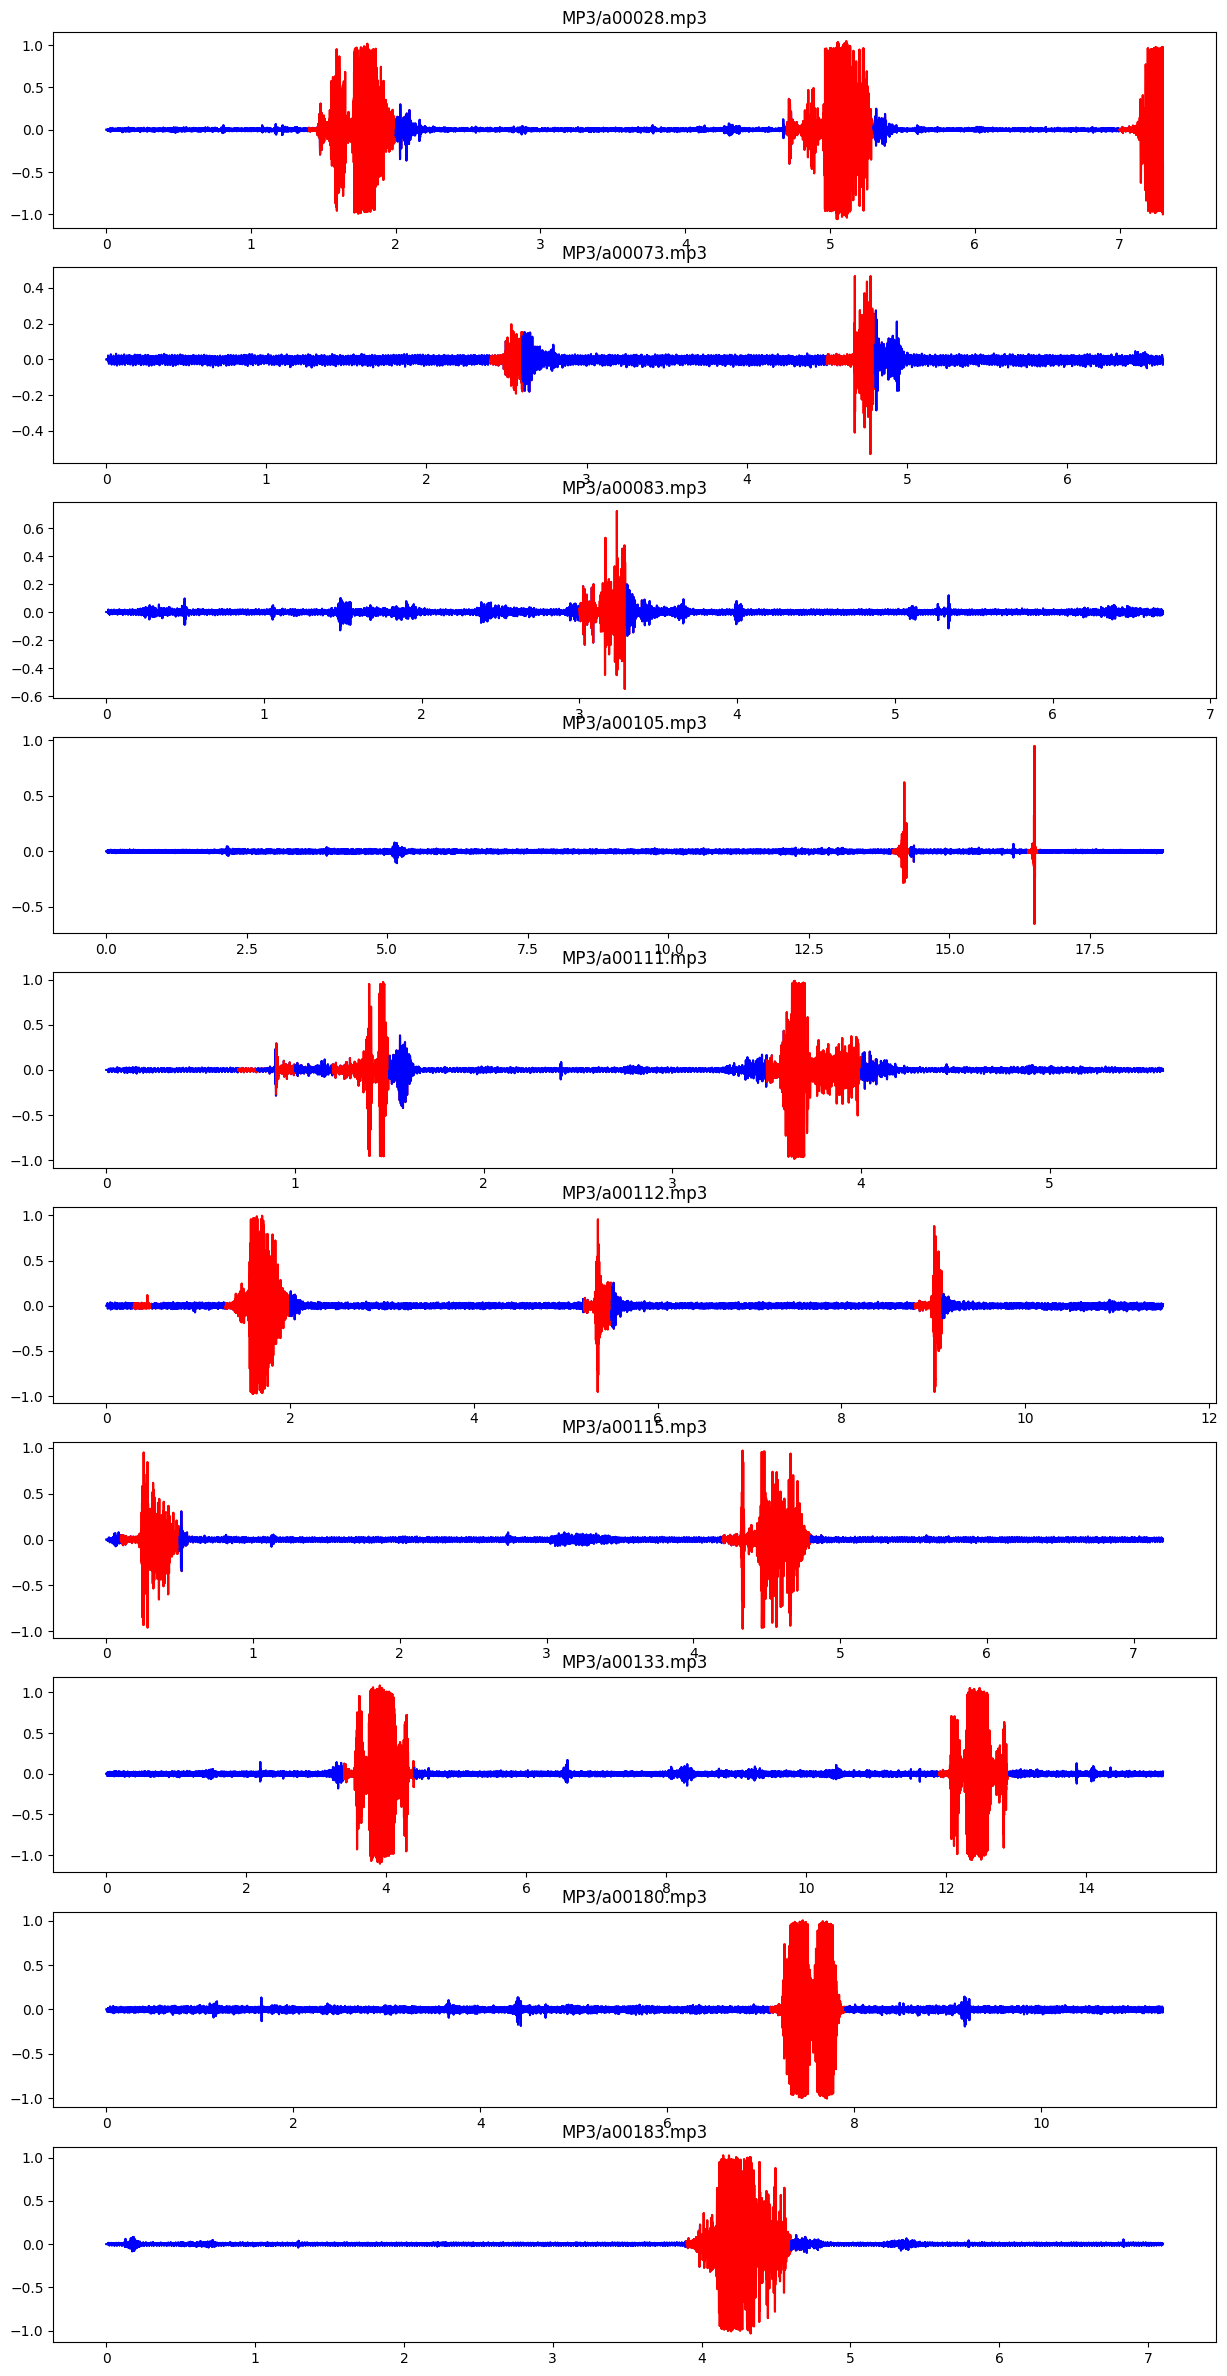

In [11]:
# detector de anomalias
from sklearn.ensemble import IsolationForest

X = []
for i, linha in enumerate(dados):
    for _, y in linha:
        X.append(y)

ano = clf.predict(df_isolation)
ano = (ano == -1)

fig, ax = plt.subplots(len(dados), 1, figsize=(15, 3*len(dados)))
n=-1
for i, linha in enumerate(dados):
    ax[i].set_title(bons[i])
    for x, y in linha:
        n+=1
        ax[i].plot(x, y, color='red' if ano[n] else 'blue')
plt.show()

In [26]:
# me mostre como extrair a energia de cada pedaço do sinal de áudio
# analisando só o áudio 28

y, sr = librosa.load('MP3/a00028.mp3', sr=None)

janela = int(0.2 * sr)
passo = int(0.1 * sr)

for i in range(0, len(y), int(passo)):
    display(f'i: {int(i/passo)} | energia: {librosa.feature.rms(y=y[i:i+janela])}')

'i: 0 | energia: [[0.002906   0.0050416  0.00635773 0.00654172 0.00665828 0.0060553\n  0.00571738 0.00637672 0.00687813 0.00704232 0.00758904 0.00768416\n  0.00779612 0.00796886 0.00739519 0.0073937  0.00630353 0.00504169]]'

'i: 1 | energia: [[0.00524299 0.00639418 0.00767037 0.00809156 0.00787093 0.00771678\n  0.00718574 0.00695075 0.00624517 0.00618914 0.00650395 0.00627301\n  0.0070839  0.00680221 0.00725575 0.00749699 0.00634869 0.00582414]]'

'i: 2 | energia: [[0.00379533 0.00470031 0.00616852 0.00641034 0.00698872 0.00722399\n  0.00757489 0.00759736 0.00712157 0.00717141 0.00703682 0.00705187\n  0.00693406 0.00666478 0.00567026 0.00673455 0.00621641 0.0055282 ]]'

'i: 3 | energia: [[0.00471279 0.00647058 0.00734089 0.00702748 0.00691751 0.00587002\n  0.00584994 0.00714983 0.00696012 0.00730324 0.00719084 0.00697127\n  0.008005   0.00943356 0.01115509 0.01172241 0.01087635 0.00906784]]'

'i: 4 | energia: [[0.00453357 0.00602482 0.00696576 0.00752954 0.00946554 0.01095683\n  0.01163758 0.01173136 0.01027707 0.00882552 0.0080285  0.00731334\n  0.00823473 0.00726343 0.00678414 0.00676166 0.00493475 0.00457523]]'

'i: 5 | energia: [[0.00547577 0.00651644 0.00780956 0.00825851 0.00752928 0.00716331\n  0.006458   0.00636716 0.00704869 0.00740931 0.00778691 0.00731916\n  0.00748942 0.00741077 0.00770027 0.00730232 0.00631245 0.00535745]]'

'i: 6 | energia: [[0.00583856 0.00670675 0.00810755 0.00724138 0.00755993 0.00759426\n  0.00717512 0.00762656 0.00749437 0.00738366 0.00828527 0.00790204\n  0.0078634  0.00779772 0.00627258 0.0068135  0.00604081 0.00526831]]'

'i: 7 | energia: [[0.00555864 0.00642697 0.00841657 0.00768914 0.00793169 0.00769056\n  0.00583618 0.00867785 0.01398538 0.01476134 0.01483532 0.01351276\n  0.00775187 0.00635356 0.00677724 0.00653039 0.00584032 0.00498862]]'

'i: 8 | energia: [[0.01375668 0.01411272 0.01451167 0.00945025 0.00668652 0.00658006\n  0.00664821 0.00695114 0.00674693 0.00687394 0.00679782 0.00590613\n  0.00643921 0.00619963 0.00589456 0.00622605 0.00516036 0.00440646]]'

'i: 9 | energia: [[0.00497547 0.00581904 0.00669678 0.0059201  0.0063532  0.00620235\n  0.00602707 0.006394   0.00600091 0.00647773 0.00632246 0.00663058\n  0.00715867 0.00676161 0.01123905 0.01102614 0.01027154 0.00989291]]'

'i: 10 | energia: [[0.00484586 0.0056904  0.00681982 0.00693302 0.00687753 0.01057469\n  0.01103762 0.01077263 0.01102823 0.00901525 0.00828874 0.00827985\n  0.00796113 0.01681066 0.01860127 0.01862867 0.01837249 0.00923334]]'

'i: 11 | energia: [[0.00622159 0.0078622  0.0085328  0.00763311 0.0094028  0.01825746\n  0.01854047 0.01866254 0.01883784 0.01683886 0.01748876 0.0175934\n  0.01647158 0.00918079 0.00765326 0.00773783 0.00674893 0.00598856]]'

'i: 12 | energia: [[0.01552568 0.01630601 0.01763696 0.01783449 0.00995177 0.00924846\n  0.0075678  0.00791331 0.0096567  0.01150113 0.01137955 0.01079116\n  0.00907285 0.00671837 0.00666729 0.00684773 0.00612864 0.00493768]]'

'i: 13 | energia: [[0.00890686 0.01080544 0.01127803 0.0106549  0.00832135 0.00658197\n  0.00659013 0.00701942 0.00672521 0.00685643 0.00688827 0.00706439\n  0.01378105 0.04516606 0.10520309 0.12122263 0.12281462 0.11497865]]'

'i: 14 | energia: [[0.00473777 0.00606222 0.00701348 0.00855735 0.02572553 0.0918171\n  0.11944124 0.12780146 0.1317278  0.10138925 0.07258634 0.08355224\n  0.16035657 0.21968354 0.30008507 0.40238237 0.38680983 0.35547823]]'

'i: 15 | energia: [[0.05528262 0.06220441 0.08204248 0.14222021 0.20439029 0.2368243\n  0.35526916 0.41754255 0.4526993  0.4520429  0.3937759  0.3598735\n  0.28764912 0.26539874 0.21905127 0.1031674  0.0700468  0.05179131]]'

'i: 16 | energia: [[0.27326626 0.30869636 0.36063266 0.31066945 0.28345403 0.2498838\n  0.16950813 0.08106111 0.22502638 0.43426272 0.5168469  0.5611615\n  0.5989603  0.54680264 0.56716996 0.5817717  0.52061933 0.43605366]]'

'i: 17 | energia: [[0.3667053  0.50065154 0.54617715 0.6016245  0.5670418  0.52451795\n  0.5815737  0.6097659  0.5784519  0.5530535  0.5118598  0.4673884\n  0.46746862 0.4500574  0.38758954 0.3380651  0.26846263 0.21685018]]'

'i: 18 | energia: [[0.3675557  0.44421342 0.50467384 0.45382905 0.46315828 0.41445068\n  0.36234698 0.30756256 0.26718006 0.2340973  0.21365473 0.15809633\n  0.13128088 0.13262561 0.11874264 0.11798137 0.09888545 0.08077714]]'

'i: 19 | energia: [[0.13314974 0.15340939 0.16869515 0.15798236 0.13150805 0.12636326\n  0.11795188 0.10770357 0.098671   0.08254741 0.10263802 0.10434338\n  0.10345244 0.11806446 0.09786909 0.11080675 0.10476064 0.0786192 ]]'

'i: 20 | energia: [[0.05156558 0.0921815  0.10403683 0.10547413 0.10691658 0.10395458\n  0.1060017  0.10881235 0.10182224 0.07303029 0.05426653 0.03149063\n  0.02744633 0.03772801 0.03391996 0.03337508 0.03130982 0.01143375]]'

'i: 21 | energia: [[0.03148748 0.03644909 0.03924264 0.02801625 0.03845218 0.03582565\n  0.03341597 0.03334954 0.0173424  0.01353368 0.0136575  0.01219762\n  0.01154302 0.01176446 0.01025449 0.00990149 0.00789888 0.00573129]]'

'i: 22 | energia: [[0.01078878 0.01190239 0.01348302 0.01079023 0.01181298 0.01136916\n  0.01019243 0.00942282 0.00792682 0.00816995 0.00826171 0.00846214\n  0.00890758 0.00872793 0.00840617 0.00768391 0.00600048 0.00450333]]'

'i: 23 | energia: [[0.00551938 0.00734959 0.00870661 0.00877069 0.00919684 0.00845238\n  0.007688   0.00729229 0.00727502 0.00703721 0.00688308 0.00690976\n  0.00593084 0.00653181 0.00705782 0.00698536 0.00638449 0.00512464]]'

'i: 24 | energia: [[0.00578307 0.00636939 0.0072392  0.0063786  0.00638049 0.006777\n  0.00671605 0.00696298 0.00623937 0.00631186 0.00658487 0.00687125\n  0.0102766  0.01008766 0.01041028 0.0102557  0.00653016 0.00576529]]'

'i: 25 | energia: [[0.00353716 0.0053609  0.0064557  0.01018839 0.0103834  0.01017965\n  0.01041121 0.00715637 0.00695538 0.00675839 0.00659019 0.00656971\n  0.0069829  0.0067418  0.00641046 0.00674603 0.00590505 0.00537047]]'

'i: 26 | energia: [[0.00403705 0.00545361 0.00660202 0.00687247 0.00697219 0.00624352\n  0.00667956 0.00697879 0.00726314 0.00833296 0.00809481 0.00730289\n  0.00734527 0.00635377 0.00620184 0.00645393 0.00642495 0.00586202]]'

'i: 27 | energia: [[0.00621839 0.0072921  0.00785021 0.00731485 0.00645429 0.00612532\n  0.00633781 0.00797018 0.01012825 0.01022357 0.01005501 0.0097389\n  0.00918449 0.01417859 0.01735101 0.0182186  0.01731048 0.01306396]]'

'i: 28 | energia: [[0.00859421 0.00904087 0.00994301 0.00911796 0.01126289 0.01717264\n  0.01733963 0.01857972 0.01688501 0.01097693 0.01044705 0.00726749\n  0.00686054 0.00658043 0.00632489 0.00597067 0.00494242 0.00410844]]'

'i: 29 | energia: [[0.00664697 0.00742411 0.00817731 0.00679646 0.00654882 0.00644383\n  0.00590718 0.00587425 0.0057282  0.00584364 0.00648445 0.00672626\n  0.00645944 0.00587979 0.00550897 0.00557117 0.00545773 0.00510219]]'

'i: 30 | energia: [[0.00444013 0.00562497 0.00667428 0.0063429  0.00602318 0.0054494\n  0.00534814 0.00605271 0.00646841 0.00732229 0.00706289 0.0069458\n  0.00704149 0.00691766 0.00718515 0.00702698 0.00640812 0.00506696]]'

'i: 31 | energia: [[0.00511285 0.00605986 0.00688309 0.00681985 0.00712706 0.00685171\n  0.00719712 0.00726971 0.00685205 0.00705342 0.00646493 0.00671924\n  0.00670217 0.00654277 0.00770549 0.00777749 0.00692188 0.00636333]]'

'i: 32 | energia: [[0.00492329 0.00580765 0.00660111 0.00596781 0.00672    0.00748635\n  0.00778329 0.00788339 0.00730722 0.00630312 0.00691541 0.0085893\n  0.00880099 0.00932802 0.00893551 0.0080475  0.00735679 0.00615282]]'

'i: 33 | energia: [[0.00386444 0.00569264 0.00780701 0.00860206 0.00930005 0.00891738\n  0.00848982 0.00875928 0.00812755 0.00848109 0.00835438 0.00729719\n  0.00759061 0.00707194 0.00659732 0.00663867 0.00584823 0.0050432 ]]'

'i: 34 | energia: [[0.0058351  0.00725418 0.00818078 0.00742734 0.00752129 0.00656355\n  0.00648613 0.00674909 0.00621434 0.00714106 0.00714214 0.00744439\n  0.00812366 0.00751482 0.00714159 0.00705849 0.00604848 0.00535196]]'

'i: 35 | energia: [[0.00502146 0.00614526 0.0077069  0.00775257 0.00760699 0.00710161\n  0.00685597 0.00709537 0.00739156 0.00828372 0.00823349 0.00834493\n  0.00819779 0.00845812 0.00936486 0.01022197 0.00957229 0.00825785]]'

'i: 36 | energia: [[0.00590493 0.00718739 0.00834608 0.0081519  0.00805487 0.00954448\n  0.01018319 0.01026116 0.01035114 0.00905986 0.00864593 0.0091756\n  0.00909148 0.00954598 0.01475874 0.01439581 0.01394059 0.0129587 ]]'

'i: 37 | energia: [[0.00629042 0.00725537 0.00909627 0.00903418 0.0086361  0.01443237\n  0.0145507  0.01440374 0.01412956 0.00772633 0.00690037 0.00685675\n  0.00766307 0.00749217 0.00700233 0.00711366 0.00589298 0.00552118]]'

'i: 38 | energia: [[0.00373136 0.00594144 0.00699863 0.00753052 0.00771435 0.00696436\n  0.00697603 0.00681666 0.00699108 0.00732874 0.00721137 0.00798843\n  0.00793549 0.00761448 0.0077672  0.00698426 0.00639402 0.00553818]]'

'i: 39 | energia: [[0.00477343 0.0063273  0.00785111 0.00765405 0.00806205 0.00762183\n  0.00725214 0.00721511 0.00764809 0.00778652 0.00786631 0.00776125\n  0.00736477 0.00719183 0.00771968 0.01023285 0.01091043 0.01044384]]'

'i: 40 | energia: [[0.00539672 0.00695888 0.00784629 0.00792365 0.00752955 0.00736903\n  0.00818742 0.01198866 0.01323816 0.01338506 0.01468058 0.01195193\n  0.01053874 0.00978435 0.00674639 0.0066285  0.0060156  0.00554057]]'

'i: 41 | energia: [[0.00854375 0.01153711 0.01261353 0.01133414 0.01020814 0.00734019\n  0.00616753 0.00726212 0.00735933 0.00781032 0.00815881 0.0078707\n  0.00845961 0.01256831 0.01410512 0.01510604 0.01604694 0.01242916]]'

'i: 42 | energia: [[0.00578561 0.00654924 0.00828839 0.00773566 0.00988793 0.0134386\n  0.0146724  0.01901424 0.02631945 0.0287898  0.02834176 0.02655291\n  0.02031759 0.01821418 0.01883053 0.01765164 0.01493034 0.00869366]]'

'i: 43 | energia: [[0.02478563 0.02687996 0.02769306 0.0232826  0.0181726  0.01906185\n  0.01819586 0.01586305 0.01352501 0.00728161 0.00701915 0.00730713\n  0.00679832 0.0067537  0.006641   0.00612077 0.00568031 0.0046324 ]]'

'i: 44 | energia: [[0.00500309 0.00594406 0.00735999 0.00676388 0.00686417 0.00657863\n  0.00611563 0.00603388 0.00619678 0.0062268  0.00612944 0.00662278\n  0.0067879  0.00743093 0.00847155 0.00863089 0.00789272 0.00680562]]'

'i: 45 | energia: [[0.00420045 0.0053176  0.00629316 0.00651655 0.00751794 0.00780215\n  0.00844007 0.00856754 0.00777841 0.00733261 0.00605794 0.00573478\n  0.0059813  0.00640032 0.02466536 0.0255409  0.0258366  0.02557521]]'

'i: 46 | energia: [[0.00398282 0.00489069 0.00588846 0.00580636 0.00639122 0.02410115\n  0.02517585 0.03195793 0.06203804 0.14509705 0.15680207 0.15829045\n  0.15075985 0.074651   0.0465103  0.03740703 0.03014053 0.01765513]]'

'i: 47 | energia: [[0.12112321 0.15305373 0.15859182 0.15870968 0.10768402 0.05700957\n  0.0397919  0.03465255 0.03814815 0.06176673 0.08567208 0.12966034\n  0.13799308 0.14430164 0.17190793 0.17123519 0.16819842 0.1540816 ]]'

'i: 48 | energia: [[0.03775067 0.06969921 0.09947973 0.13523419 0.13894905 0.16336112\n  0.18539254 0.17373537 0.172565   0.14424112 0.09664197 0.07489438\n  0.10004396 0.27724037 0.39619088 0.4355851  0.45101622 0.36704564]]'

'i: 49 | energia: [[0.0610067  0.06960849 0.07594875 0.09739722 0.22367762 0.38364825\n  0.41929778 0.5075094  0.55894667 0.50761753 0.51088816 0.55629903\n  0.57875544 0.6270958  0.68239623 0.6668581  0.5917937  0.49839383]]'

'i: 50 | energia: [[0.39606842 0.46042293 0.5593359  0.54060113 0.62313145 0.66062766\n  0.6779975  0.6729731  0.68930435 0.6880309  0.66674423 0.6239684\n  0.5616494  0.4791906  0.4112273  0.37205735 0.28638083 0.25756368]]'

'i: 51 | energia: [[0.5003554  0.57860595 0.6490118  0.59005475 0.50325286 0.46152514\n  0.38551936 0.3770033  0.37015638 0.37261194 0.42889556 0.4007607\n  0.40698776 0.35816407 0.25863284 0.22276023 0.1234618  0.08127181]]'

'i: 52 | energia: [[0.2785405  0.40584147 0.42930102 0.4124546  0.39283168 0.26579666\n  0.23401034 0.14065838 0.09365663 0.08933765 0.07379502 0.0747008\n  0.07623106 0.06499652 0.07730038 0.07680218 0.06697911 0.05839134]]'

'i: 53 | energia: [[0.05894886 0.06572253 0.07363817 0.07568394 0.06495636 0.07836977\n  0.07812641 0.07362089 0.06656983 0.04318187 0.03062649 0.02912851\n  0.02167618 0.01697152 0.01256034 0.01151103 0.00717574 0.00576273]]'

'i: 54 | energia: [[0.02547718 0.02957645 0.03038803 0.02320937 0.01960781 0.01301909\n  0.01172411 0.00968398 0.00757285 0.00748789 0.00740707 0.00640053\n  0.00620455 0.00635312 0.00614439 0.00712769 0.00809241 0.00736145]]'

'i: 55 | energia: [[0.00504703 0.00610895 0.00683225 0.00618508 0.00606835 0.00594583\n  0.00671167 0.01165395 0.01566951 0.01634703 0.0174254  0.01522155\n  0.01154335 0.01054388 0.00822988 0.0069481  0.00567997 0.00471921]]'

'i: 56 | energia: [[0.01418723 0.0162567  0.01699915 0.01174555 0.01120035 0.00815658\n  0.0073613  0.00693516 0.00594316 0.00716896 0.00706433 0.00827155\n  0.00860377 0.00782395 0.00770814 0.00610904 0.00507247 0.00428751]]'

'i: 57 | energia: [[0.00464884 0.00623504 0.00829646 0.00839944 0.00840547 0.00765356\n  0.00622805 0.00577016 0.00613599 0.00655765 0.00626231 0.00653444\n  0.00592055 0.00545297 0.00584923 0.00536375 0.00495824 0.00440008]]'

'i: 58 | energia: [[0.00501146 0.00568102 0.00632768 0.00594996 0.00566369 0.00568008\n  0.00568223 0.00596733 0.00640117 0.00695658 0.0069412  0.0066828\n  0.00667903 0.00605715 0.00672159 0.00803336 0.00765065 0.00718948]]'

'i: 59 | energia: [[0.00521932 0.0064177  0.00708347 0.00660673 0.00657661 0.00618831\n  0.00737448 0.00842714 0.00992162 0.01119572 0.01186993 0.01251818\n  0.01158707 0.01140372 0.00998992 0.00861346 0.00781882 0.00542722]]'

'i: 60 | energia: [[0.00820292 0.01072114 0.01240749 0.01197593 0.01125437 0.01007678\n  0.00895378 0.00842025 0.00786637 0.00767998 0.00716346 0.00701336\n  0.00693399 0.00631469 0.00658629 0.00653904 0.00596002 0.00490802]]'

'i: 61 | energia: [[0.00464226 0.00640418 0.00694119 0.00671218 0.00696959 0.00645481\n  0.00685219 0.0064815  0.00616897 0.00576665 0.00552935 0.00583837\n  0.00600367 0.00622409 0.00646683 0.00674137 0.0062996  0.00540733]]'

'i: 62 | energia: [[0.00400156 0.00480799 0.00587688 0.00571078 0.00611493 0.00646077\n  0.00663387 0.00709671 0.0071608  0.00739949 0.00699111 0.0074188\n  0.00703912 0.00687996 0.00824436 0.00791326 0.00749224 0.0065894 ]]'

'i: 63 | energia: [[0.00514494 0.00636072 0.00724461 0.00723334 0.00704104 0.00752743\n  0.00787761 0.00821324 0.00803238 0.00731567 0.00668219 0.00639814\n  0.0067736  0.006784   0.00671792 0.00870327 0.00808097 0.00742206]]'

'i: 64 | energia: [[0.00472047 0.00565473 0.00680654 0.00669465 0.00667386 0.00664771\n  0.00804857 0.00849004 0.00834638 0.00824016 0.00646772 0.00545942\n  0.00568799 0.00590369 0.00636367 0.00660516 0.00602665 0.00512225]]'

'i: 65 | energia: [[0.00362159 0.00503305 0.00529759 0.00560939 0.00605839 0.00618962\n  0.00677114 0.00646046 0.00608048 0.00586114 0.00558524 0.006223\n  0.00649039 0.0075446  0.00776058 0.00722602 0.00692977 0.00469279]]'

'i: 66 | energia: [[0.00407353 0.00495956 0.00575753 0.00616551 0.00730131 0.00766219\n  0.00758888 0.00789345 0.00704736 0.00663568 0.00674603 0.00623693\n  0.00614207 0.00604136 0.00642425 0.00597021 0.00509872 0.0044106 ]]'

'i: 67 | energia: [[0.00500316 0.00587879 0.00656339 0.00612861 0.00628992 0.0061\n  0.00620992 0.00575951 0.00679461 0.00790534 0.00807499 0.00791742\n  0.00682994 0.00562378 0.00568405 0.00607994 0.0058895  0.00511901]]'

'i: 68 | energia: [[0.00681302 0.00766808 0.00815319 0.00731952 0.00553742 0.00567545\n  0.00580303 0.00609206 0.00671139 0.00656918 0.00661678 0.00683356\n  0.00669804 0.00628611 0.00637811 0.00651185 0.00573307 0.00511618]]'

'i: 69 | energia: [[0.00464478 0.00565346 0.00641045 0.0064241  0.00653147 0.00643464\n  0.0065458  0.00636546 0.00611354 0.01015149 0.0100483  0.01030763\n  0.01056    0.01014862 0.0117481  0.01524186 0.0152187  0.01285763]]'

'i: 70 | energia: [[0.00833867 0.00939492 0.01015046 0.01051985 0.00917103 0.01141255\n  0.0137915  0.01724119 0.02259833 0.03107659 0.04552536 0.14838737\n  0.18022543 0.20094012 0.32800683 0.40813985 0.44672263 0.43720183]]'

'i: 71 | energia: [[0.02135275 0.0355446  0.08610879 0.16689451 0.19268687 0.27451757\n  0.36532554 0.49012306 0.61043924 0.68222314 0.7302387  0.74548197\n  0.7637312  0.7842844  0.7976692  0.8302412  0.75203514 0.6339626 ]]'

'i: 72 | energia: [[0.49569038 0.6129494  0.7215401  0.76762253 0.78230613 0.8013035\n  0.8224636  0.84173846 0.85990506 0.8197079  0.70188946]]'

'i: 73 | energia: [[0.59218085 0.60250086 0.60250086]]'